### Import Packages

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

C:\Users\marys\AppData\Local\Temp\ipykernel_10948\2967179035.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


#### Pfade definieren

In [2]:
#Aktueller Pfad (current path)
cur_path = os.getcwd()
pics_path=os.path.join(cur_path,"Bildervorbearbeitung","Bilder","Auswertung","Zugeschnittene_Bilder")
xlsx_data_path=os.path.join(cur_path,"Bildervorbearbeitung","Bilder","Auswertung","xlsx")

### Daten einladen
Festlegen  der Klassen: Thereshold-array zeigt 3 verscheidene Abstufungen, innerhalb von 1,5 % engere Klassen, da bis zu 1 % die Probe/das Bauteil noch als i.O gewertet wird. Danach etwas weiterer Abstufungen. Ab 10 % Abstufungen von 10 %, da hier das Bauteil schon sehr porös ist und zusätzlich solche Trainingsdaten im bisherigen Trainingsdatensatz nicht existieren. 

enumerate heißt es zählt über das Array nacheinander drüber. 0.01 entspricht der Klasse 1, 0.02 entspricht der Klasse 2 ect. 
Start=1 heißt, dass es bei Klasse 1 beginnen soll. 

Schließlich wird eine neue Liste abgespeichert

In [3]:
df_path = os.path.join(xlsx_data_path, "Porositaet_Zugeschnittene_Bilde.xlsx")
df_pre = pd.read_excel(df_path)

In [4]:
import numpy as np

theresholds_narrow = np.arange(0.01, 1.5, 0.01)
thereshold_middle = np.arange(1.5,10.5,0.5)
thereshold_wide = np.arange(20,110,10)
theresholds = np.concatenate((theresholds_narrow, thereshold_middle, thereshold_wide))
print(theresholds)
print("Anzahl der Klassen:", len(theresholds))


def get_class(porosity, thresholds):
    for i, threshold in enumerate(thresholds, start=1):
        if porosity <= threshold:
            return i
    return len(thresholds)

df_pre['Klassen'] = df_pre['Porositaet'].apply(lambda x: get_class(x, theresholds))

# Speichern der Ergebnisse in einer neuen Liste
new_xlsx_path = os.path.join(xlsx_data_path, 'Porositaet_Zugeschnittene_Bilder_mit_Klassen.xlsx')
df_pre.to_excel(new_xlsx_path, index=False)


[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 7.00e-02 8.00e-02
 9.00e-02 1.00e-01 1.10e-01 1.20e-01 1.30e-01 1.40e-01 1.50e-01 1.60e-01
 1.70e-01 1.80e-01 1.90e-01 2.00e-01 2.10e-01 2.20e-01 2.30e-01 2.40e-01
 2.50e-01 2.60e-01 2.70e-01 2.80e-01 2.90e-01 3.00e-01 3.10e-01 3.20e-01
 3.30e-01 3.40e-01 3.50e-01 3.60e-01 3.70e-01 3.80e-01 3.90e-01 4.00e-01
 4.10e-01 4.20e-01 4.30e-01 4.40e-01 4.50e-01 4.60e-01 4.70e-01 4.80e-01
 4.90e-01 5.00e-01 5.10e-01 5.20e-01 5.30e-01 5.40e-01 5.50e-01 5.60e-01
 5.70e-01 5.80e-01 5.90e-01 6.00e-01 6.10e-01 6.20e-01 6.30e-01 6.40e-01
 6.50e-01 6.60e-01 6.70e-01 6.80e-01 6.90e-01 7.00e-01 7.10e-01 7.20e-01
 7.30e-01 7.40e-01 7.50e-01 7.60e-01 7.70e-01 7.80e-01 7.90e-01 8.00e-01
 8.10e-01 8.20e-01 8.30e-01 8.40e-01 8.50e-01 8.60e-01 8.70e-01 8.80e-01
 8.90e-01 9.00e-01 9.10e-01 9.20e-01 9.30e-01 9.40e-01 9.50e-01 9.60e-01
 9.70e-01 9.80e-01 9.90e-01 1.00e+00 1.01e+00 1.02e+00 1.03e+00 1.04e+00
 1.05e+00 1.06e+00 1.07e+00 1.08e+00 1.09e+00 1.10e

In [5]:
df_path = new_xlsx_path
df = pd.read_excel(df_path)
df.head()

,Bildname,Porositaet,Klassen
0,P_006_quad_Winkel_180_crp_x10_y10_Winkel_180.png,0.4636,47
1,P_006_quad_Winkel_180_crp_x10_y10_Winkel_270.png,0.2652,27
2,P_006_quad_Winkel_180_crp_x10_y10_Winkel_360.png,0.0652,7
3,P_006_quad_Winkel_180_crp_x10_y10_Winkel_90.png,0.2640,27
4,P_006_quad_Winkel_180_crp_x10_y11_Winkel_180.png,0.4188,42


#### Umwandeln von Bildern und Werten aus der Liste in ein Array

In [6]:
X = []
y = [] 

import_data = pd.read_excel(df_path)
for index, row in import_data.iterrows():
    img_name = row['Bildname']
    img_path = os.path.join(pics_path, img_name)
    img = cv2.imread(img_path)
    X.append(img)
    y.append(row['Klassen'])

print("Anzahl der Datenpaare:",len(y))

X = np.array(X)
y = np.array(y)

Anzahl der Datenpaare: 1456


#### Train-Test-Split

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

y_train_cat = to_categorical(y_train, num_classes=176)
y_test_cat = to_categorical(y_test, num_classes=176)
print(y_test_cat)
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[  0   0   0]
   [237 237 237]
   [235 235 235]
   ...
   [242 242 242]
   [240 240 240]
   [242 242 242]]

  [[  0   0   0]
   [238 238 238]
   [236 236 236]
   ...
   [242 242 242]
   [242 242 242]
   [242 242 242]]

  [[  0   0   0]
   [236 236 236]
   [234 234 234]
   ...
   [241 241 241]
   [241 241 241]
   [240 240 240]]

  ...

  [[  0   0   0]
   [234 234 234]
   [235 235 235]
   ...
   [240 240 240]
   [241 241 241]
   [242 242 242]]

  [[  0   0   0]
   [235 235 235]
   [235 235 235]
   ...
   [240 240 240]
   [240 240 240]
   [240 240 240]]

  [[  0   0   0]
   [234 234 234]
   [234 234 234]
   ...
   [240 240 240]
   [240 240 240]
   [240 240 240]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[234 234 234]
   [237 237 237]
   [236 236 236]
   ...


Eingangsdaten Bild: Pixelgröße und Eingangsfarbkanäle (500, 500, 3)
Porosität [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


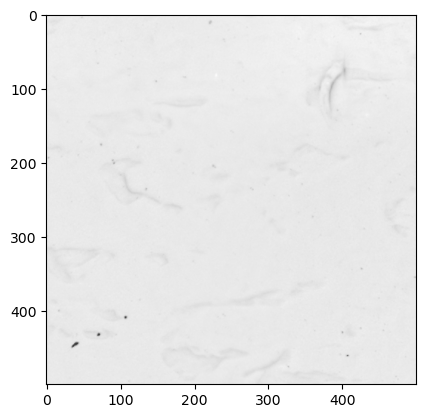

In [8]:
plt.imshow(X_train[1000])
plt.show

print("Eingangsdaten Bild: Pixelgröße und Eingangsfarbkanäle", X_train[1000].shape)
print("Porosität",y_train_cat[1000])

### Modell erstellen

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop
from numpy import reshape

model = Sequential()

# model.add(Lambda(standardize, input_shape=(28, 28, 1)))

# model.add(Reshape((500, 500, 3), input_shape=(None, 500, 500, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(500, 500, 3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(176, activation="softmax"))  # 176 verschiedene Klassen (siehe oben)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 248, 248, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 248, 248, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 246, 246, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 244, 244, 128)    

#### Modell kompalieren

In [10]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(
    X_train,
    y_train_cat,
    epochs = 5,
    batch_size = 32
)

Epoch 1/5

